In [1]:
import sys
sys.path.append('./')
sys.path.append('./../../../../')
sys.path.append('./../../../../designer')
sys.path.append('./../../../../designer/script')

from spectrum import Spectrum
from film import MultiMaterialFilm, TwoMaterialFilm
from optimizer.adam import AdamThicknessOptimizer
from optimizer.archive.LM_gradient_descent import LM_optimize_d_simple
from design import BaseDesign

from utils.substitute import optimal_and_thin_film_approx_substitution_onestep_new, equal_optical_thickness_new, equal_optical_thickness
from utils.loss import calculate_RMS

import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
wls = np.linspace(390, 710, 320)
wls_more = np.linspace(300, 800, 500)

target_spec_params = 20., wls
target = Spectrum(*target_spec_params, np.ones_like(wls))

reverse = lambda arr: np.ascontiguousarray(np.flip(arr))
d_init = reverse(np.loadtxt('./before')) # NOTE: the structures are in the reverse order
materials_init = reverse(np.loadtxt('./before_materials', dtype='str'))
d_eqot_benchmark = reverse(np.loadtxt('./after'))
materials_eqot_benchmark = reverse(np.loadtxt('./after_materials', dtype='str'))

print(materials_eqot_benchmark)
print(d_eqot_benchmark)

film_init = MultiMaterialFilm(materials_init, 'SiO2_exp', d_init)
# xc
film_eqot_benchmark = MultiMaterialFilm(materials_eqot_benchmark, 'SiO2_exp', d_eqot_benchmark)
# ours
film_eqot = copy.deepcopy(film_init)
film_optim = copy.deepcopy(film_init)


all_films = [film_init, film_eqot_benchmark, film_eqot, film_optim]
for film in all_films:
    film.add_spec_param(*target_spec_params)

['MgF2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc'
 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc']
[ 93.333 117.232  51.859   5.183 135.813  11.153 207.212  24.928  12.108
  90.294  31.529  15.26   97.318]


In [3]:
# w/o GD. NOTE: need to wait for compilation of CUDA at first run
d_min = 5.
equal_optical_thickness_new(film_eqot, d_min)
res = optimal_and_thin_film_approx_substitution_onestep_new(film_optim, d_min)
print(res)
print(calculate_RMS(film_optim, film_init))
print(calculate_RMS(film_eqot, film_init))

/home/vipuser/miniconda3/envs/tf_design_2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 20 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


(2, [(1.004793914265939+0j), (1.186253763127466+0j)])


/home/vipuser/miniconda3/envs/tf_design_2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 20 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


0.003764502190777703
0.0037727095392426748


(0.97, 1.0)

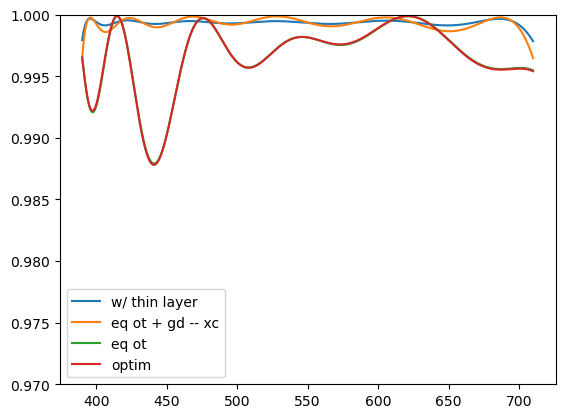

In [4]:
fig, ax = plt.subplots(1, 1)

ax.plot(wls, film_init.get_spec().get_T(), label='w/ thin layer')
ax.plot(wls, film_eqot_benchmark.get_spec().get_T(), label='eq ot + gd -- xc')
ax.plot(wls, film_eqot.get_spec().get_T(), label='eq ot')
ax.plot(wls, film_optim.get_spec().get_T(), label='optim')
ax.legend()
ax.set_ylim(0.97, 1)



This is weird. In our other experiments optim method seems to greatly outperform the equal ot...

Okay so i guess it is simply bad luck. Our strategy could not offer a result consistently outperforming eqot.

[ 7.74540119 13.50714306 11.31993942  9.98658484  5.5601864   5.5599452
  4.58083612 12.66176146 10.01115012 11.08072578  4.20584494 13.69909852
 12.32442641  6.12339111  5.81824967  5.8340451   7.04242243  9.24756432
  8.31945019  6.9122914  10.11852895  5.39493861  6.92144649  7.66361843
  8.56069984 11.85175961  5.99673782  9.14234438  9.92414569  4.46450413
 10.07544852  5.70524124  4.65051593 13.48885537 13.65632033 12.08397348
  7.04613769  4.97672114 10.84233027  8.40152494  5.22038235  8.9517691
  4.34388521 13.09320402  6.58779982 10.62522284  7.11711076  9.20068021
  9.46710279  5.84854456 13.69584628 11.75132823 13.39498942 12.9482735
  9.97899979 13.21874235  4.88492502  5.95982862  4.45227289  7.25330331
  7.8867729   6.71349032 12.28737509  7.56753327  6.8093451   9.42696083
  5.40924225 12.02196981  4.74550644 13.86886937 11.72244769  5.98715682
  4.05522117  3.         11.06857344 11.29007168 11.71270347  4.74044652
  7.58465729  5.1586906   3.         10.23298127  7.30

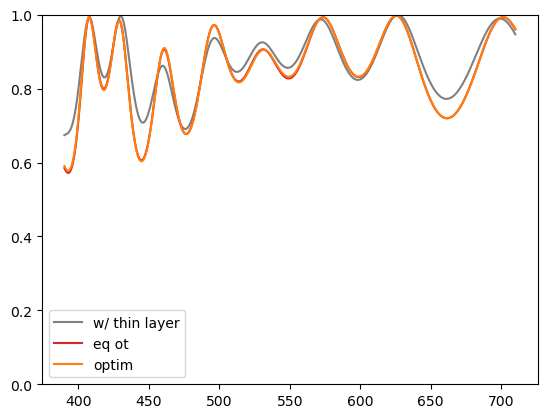

In [4]:
# toy scenario

d_min = 3
layer_number = 200
thin_number = 5

np.random.seed(42)
d_init = np.random.random(layer_number) * 10 + d_min + 1

thin_idx = np.arange(1, layer_number - 1)
np.random.shuffle(thin_idx)
thin_idx = thin_idx[:thin_number]

d_init[thin_idx] = d_min # artificial thin films
print(d_init)

film = TwoMaterialFilm('Ta2O5_xc', 'SiO2_xc', 'BK7', d_init)
film.add_spec_param(20., wls)

film_eqot = copy.deepcopy(film)
equal_optical_thickness_new(film_eqot, d_min + 1)
print(film_eqot.get_d())

film_optim = copy.deepcopy(film)
res = optimal_and_thin_film_approx_substitution_onestep_new(film_optim, d_min + 1)
print('optim sub res:', res)
fig, ax = plt.subplots(1, 1)

ax.plot(wls, film.get_spec().get_T(), label='w/ thin layer', c='grey')
ax.plot(wls, film_eqot.get_spec().get_T(), label='eq ot', c='C3')
ax.plot(wls, film_optim.get_spec().get_T(), label='optim', c='C1')
ax.legend()
ax.set_ylim(0., 1)

print(calculate_RMS(film, film_optim))
print(calculate_RMS(film, film_eqot))